In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

In [66]:
df = pd.read_csv('wine-reviews.csv', usecols = ['country', 'description', 'points', 'price', 'variety', 'winery'])

In [67]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [68]:
df = df.dropna(subset=["description", "points"])

In [69]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


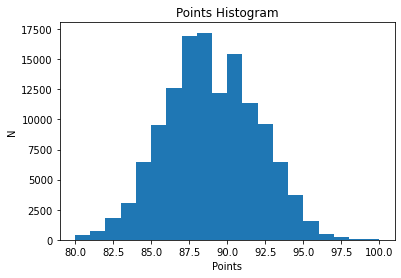

In [70]:
plt.hist(df.points, bins=20)
plt.title('Points Histogram')
plt.ylabel('N')
plt.xlabel('Points')
plt.show()

In [71]:
df['label'] = (df.points >= 90).astype(int)
df = df[['description', 'label']]

In [72]:
df.tail()

,description,label
129966,Notes of honeysuckle and cantaloupe sweeten th...,1
129967,Citation is given as much as a decade of bottl...,1
129968,Well-drained gravel soil gives this wine its c...,1
129969,"A dry style of Pinot Gris, this is crisp with ...",1
129970,"Big, rich and off-dry, this is powered by inte...",1


In [84]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

In [85]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df["description"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [86]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

In [105]:
embedding = "https://tfhub.dev/google/nnlm-en-dim128/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [106]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 128), dtype=float32, numpy=
array([[ 0.38232034, -0.21034592,  0.24386942, ..., -0.17145996,
         0.1723118 , -0.17305832],
       [ 0.11152841, -0.24295478,  0.13471372, ...,  0.03210654,
        -0.01534943, -0.13833189],
       [ 0.5560424 , -0.11178935,  0.08755804, ..., -0.29218596,
         0.08447105,  0.07338043],
       ...,
       [ 0.7495931 , -0.15860452,  0.12557802, ..., -0.22916274,
         0.13065027, -0.00393752],
       [ 0.6303719 , -0.1674922 ,  0.03275198, ..., -0.12431481,
         0.03536024,  0.02598616],
       [ 0.5297499 , -0.3243217 ,  0.23531626, ..., -0.15320003,
         0.10626443,  0.09967258]], dtype=float32)>

In [107]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [108]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [109]:
model.evaluate(train_data)

102/102 [==============================] - 3s 19ms/step - loss: 0.7145 - accuracy: 0.3783


[0.7144547700881958, 0.37832769751548767]

In [110]:
model.evaluate(valid_data)

13/13 [==============================] - 0s 15ms/step - loss: 0.7151 - accuracy: 0.3736


[0.7151283025741577, 0.37362468242645264]

In [ ]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
 70/102 [===================>..........] - ETA: 1:00 - loss: 0.2938 - accuracy: 0.8788

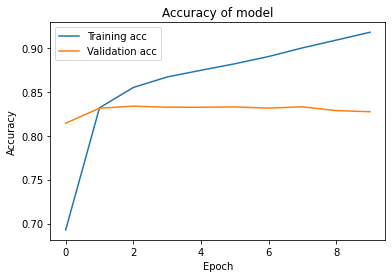

In [101]:
plt.plot(history.history['accuracy'], label='Training acc')
plt.plot(history.history['val_accuracy'], label='Validation acc')
plt.title('Accuracy of model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

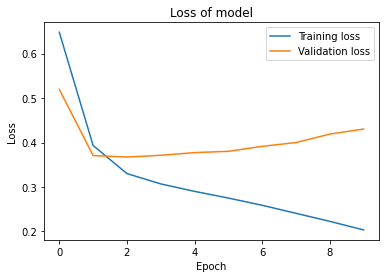

In [102]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss of model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
model.evaluate(test_data)